# LSST CCOB ghost study distance

Explore the properties of the reduced distance I have defined

## TODO
- plot 2D and 3D distances against the value of a rotation angle of one optical element



In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [4]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [5]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [6]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

Direct path is number 28
  central impact point is (0.099478, -0.000015)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 662.8139


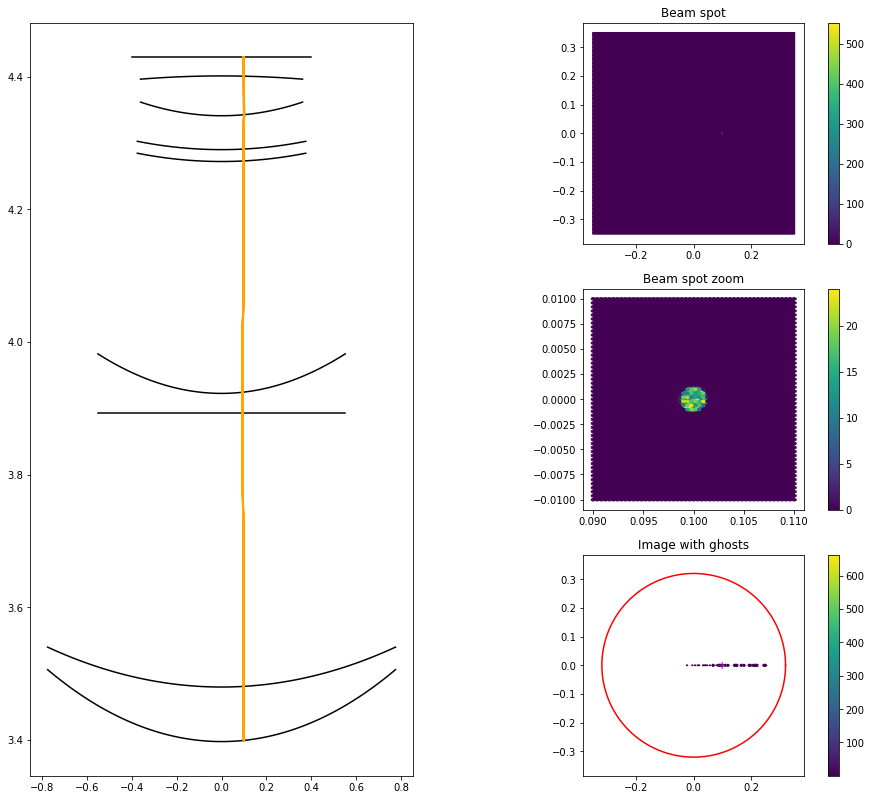

0

In [7]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


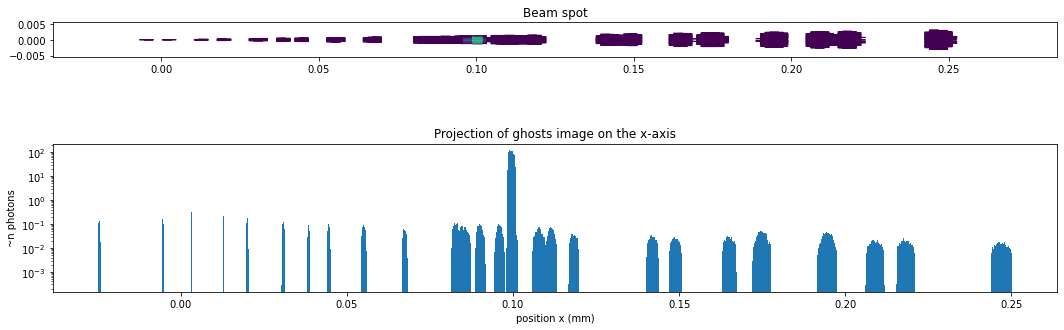

0

In [8]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


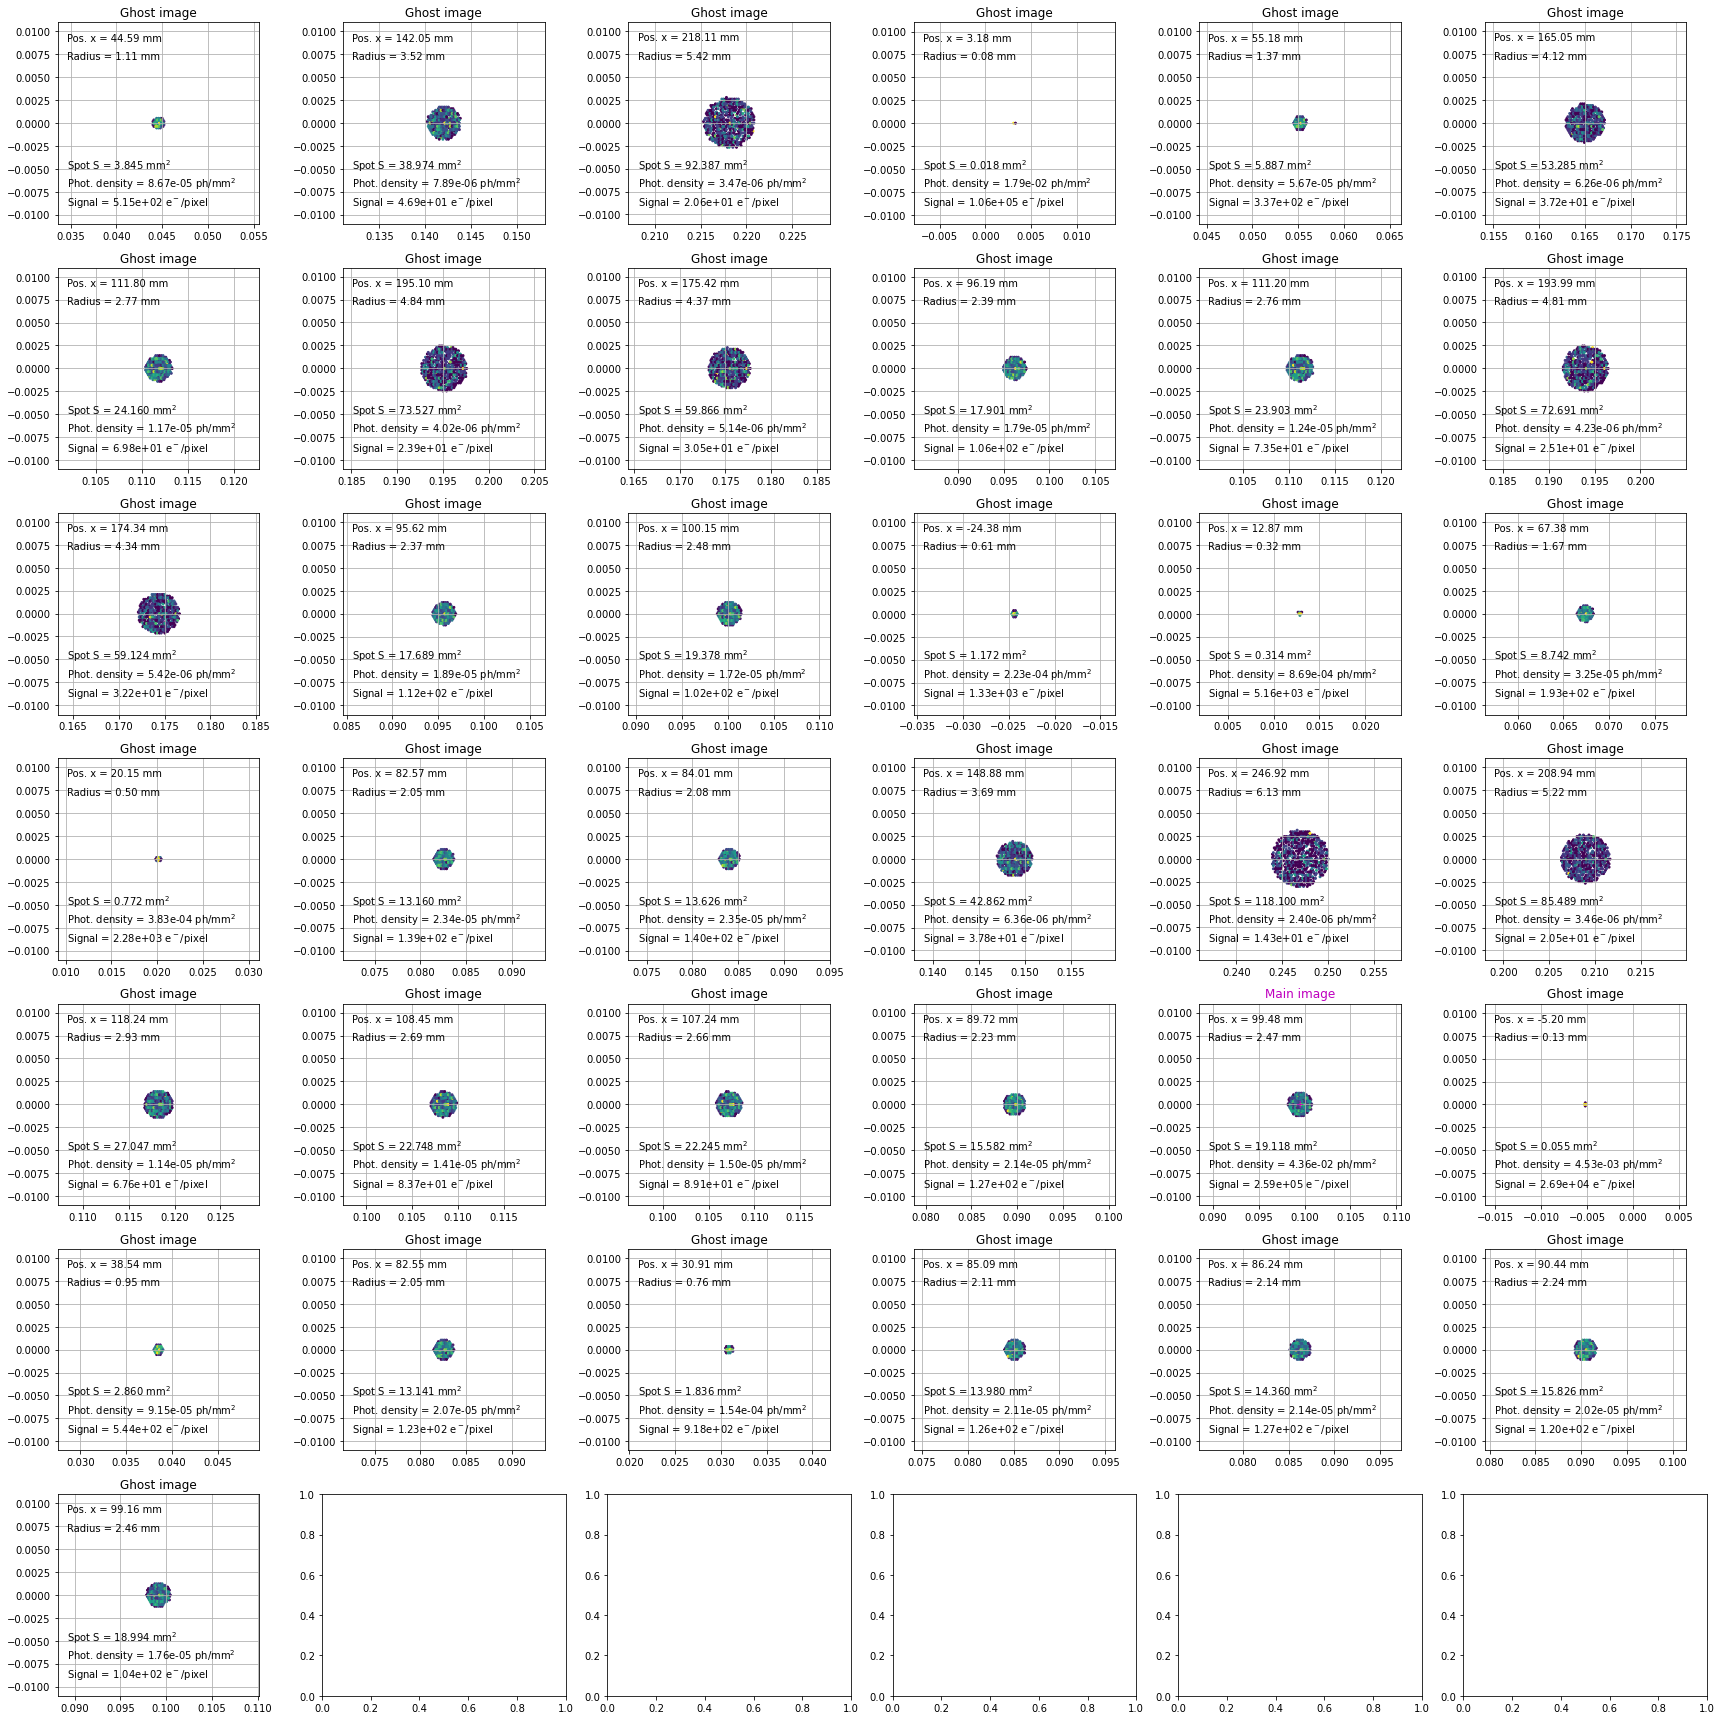

In [9]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [10]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1)
data_frame_1.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085094,0.000534,-1.258930e-05,0.000534,0.002116,0.002103,0.002109,6.551335e-06,13.979851,125.590928
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086241,0.000541,-1.275907e-05,0.000541,0.002145,0.002131,0.002138,6.680062e-06,14.360025,127.307351
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",-0.005197,0.000035,7.678028e-07,0.000035,0.000137,0.000128,0.000133,4.462546e-06,0.055487,26920.398807
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.038538,0.000241,-5.701819e-06,0.000241,0.000956,0.000952,0.000954,1.765416e-06,2.860122,543.791839
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082552,0.000517,-1.221358e-05,0.000517,0.002050,0.002040,0.002045,5.111895e-06,13.141160,123.234246
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.030906,0.000193,-4.572806e-06,0.000193,0.000765,0.000764,0.000765,7.939065e-07,1.836477,918.179033
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090442,0.000569,-1.337999e-05,0.000569,0.002254,0.002235,0.002244,9.348163e-06,15.826169,120.276485
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099161,0.000622,-1.467034e-05,0.000622,0.002467,0.002451,0.002459,8.285369e-06,18.994167,104.347996
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.111200,0.000698,-1.645122e-05,0.000698,0.002769,0.002748,0.002758,1.024579e-05,23.902867,73.453220
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.193992,0.001217,-2.870010e-05,0.001217,0.004826,0.004794,0.004810,1.607816e-05,72.691242,25.149339


In [64]:
def scan_dist_rotation(telescope, ref_data_frame, optic_name='L2', axis='x', angles_list=[-0.02, -0.01, 0., 0.01, 0.02]):
    ''' Profile likelihood
    '''
    distances_2d = list()
    distances_3d = list()
    for angle in angles_list:
        df_i, gs_i = simulator.full_rotation(telescope, optic_name='L2', axis='y', angle=angle, beam_config=BEAM_CONFIG_1)
        match_i = match_ghosts(data_frame_1, df_i)
        dist_i = compute_reduced_distance(match_i)
        distances_3d.append(dist_i)

        match_i2 = match_ghosts(data_frame_1, df_i)
        dist_i2 = compute_2d_reduced_distance(match_i2)
        distances_2d.append(dist_i2)
    
        print(f'{angle} ', end='', flush=True)
    
    return angles_list, distances_2d, distances_3d




In [65]:
angles = [i*0.01 for i in range(-50, 51)]
angles_list, distances_2d, distances_3d = \
    scan_dist_rotation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x', angles_list=angles)

-0.5 -0.49 -0.48 -0.47000000000000003 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41000000000000003 -0.4 -0.39 -0.38 -0.37 -0.36 -0.35000000000000003 -0.34 -0.33 -0.32 -0.31 -0.3 -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2 -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35000000000000003 0.36 0.37 0.38 0.39 0.4 0.41000000000000003 0.42 0.43 0.44 0.45 0.46 0.47000000000000003 0.48 0.49 0.5 

ValueError: x and y must have same first dimension, but have shapes (21,) and (101,)

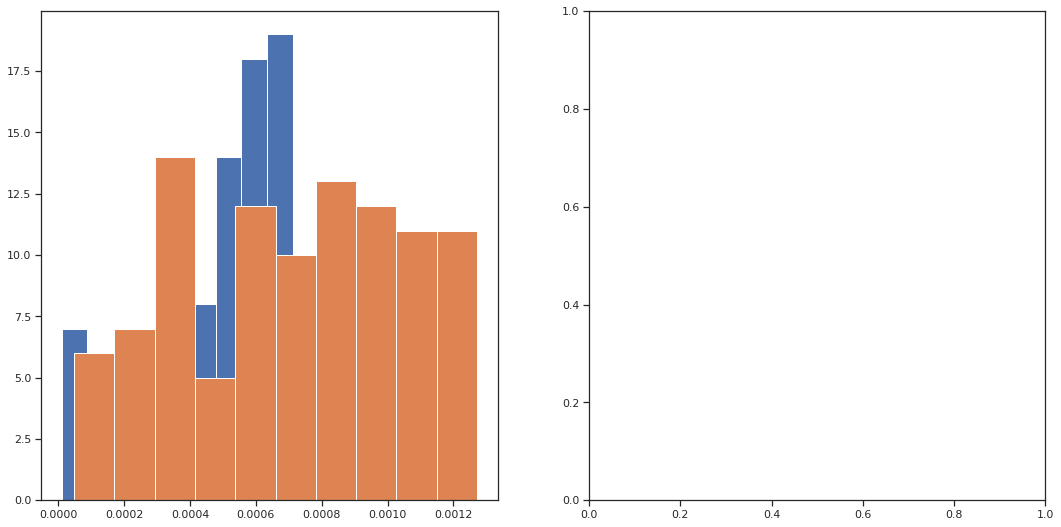

In [96]:
plotter.plot_distances_rotation_scan(angles_list, distances_2d, distances_3d)

In [67]:
angles_list, distances_2d_y, distances_3d_y = \
    scan_dist_rotation(telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='y', angles_list=angles)

-0.5 -0.49 -0.48 -0.47000000000000003 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41000000000000003 -0.4 -0.39 -0.38 -0.37 -0.36 -0.35000000000000003 -0.34 -0.33 -0.32 -0.31 -0.3 -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2 -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35000000000000003 0.36 0.37 0.38 0.39 0.4 0.41000000000000003 0.42 0.43 0.44 0.45 0.46 0.47000000000000003 0.48 0.49 0.5 

ValueError: x and y must have same first dimension, but have shapes (21,) and (101,)

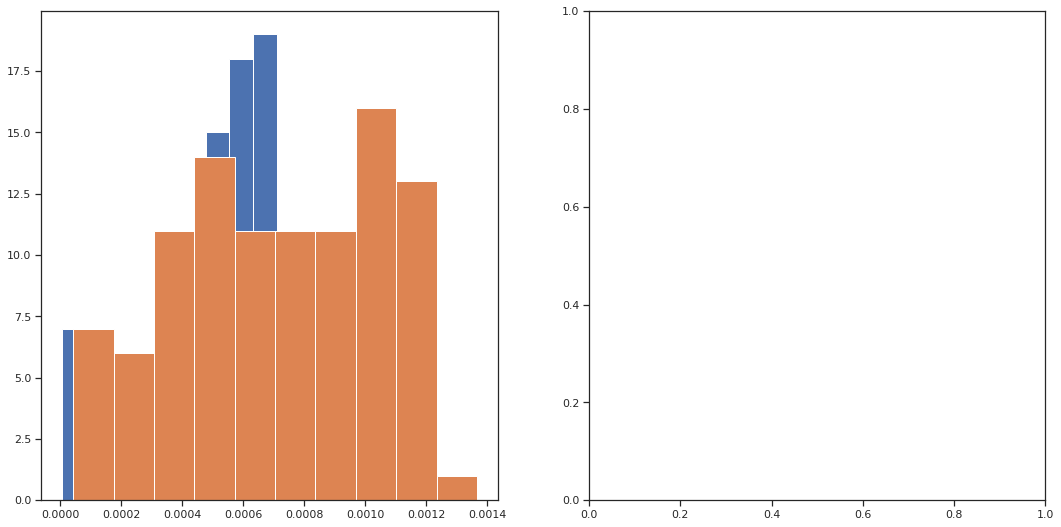

In [97]:
plotter.plot_distances_rotation_scan(angles_list, distances_2d_y, distances_3d_y)

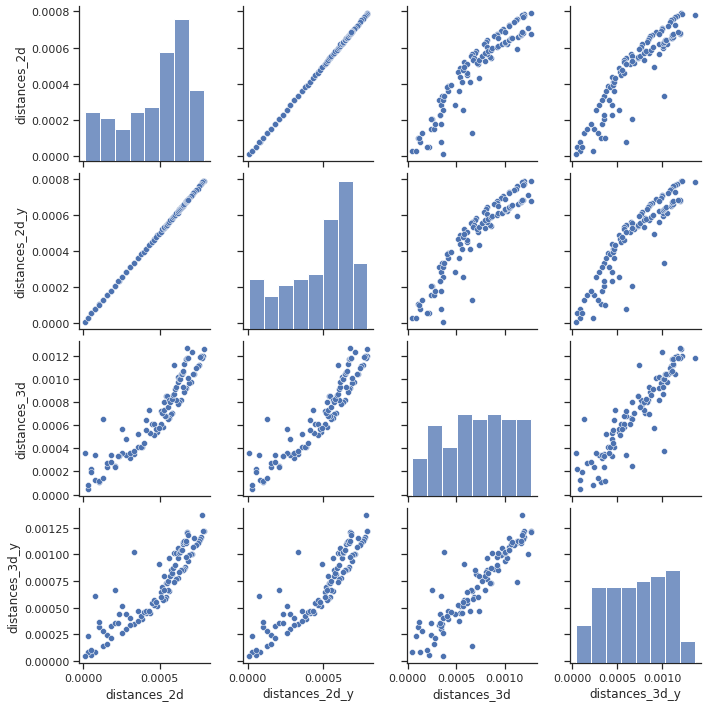

In [76]:
# correlations between distances
plt.rcParams["figure.figsize"] = [24, 24]
pd_distances = pd.DataFrame(
    {
        "distances_2d": np.array(distances_2d, dtype="float"),
        "distances_2d_y": np.array(distances_2d_y, dtype="float"),
        "distances_3d": np.array(distances_3d, dtype="float"),
        "distances_3d_y": np.array(distances_3d_y, dtype="float"),
    }
)

import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(pd_distances)

In [93]:
# use a tweaked telescope as a basis before the scan
tw = {'L1':{'rotations':[0.1, 0., 0.]}}
tweaked_telescope = tweak_optics.tweak_telescope(telescope, tweaks=tw)
tweak_optics.make_optics_reflective(tweaked_telescope)


0.02

In [94]:
angles = [i*0.01 for i in range(-10, 11)]
angles_list, distances_2d_L1rot, distances_3d_L1rot = \
    scan_dist_rotation(tweaked_telescope, ref_data_frame=data_frame_1, optic_name='L2', axis='x', angles_list=angles)

-0.1 -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 

(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from -0.5 to +0.5 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

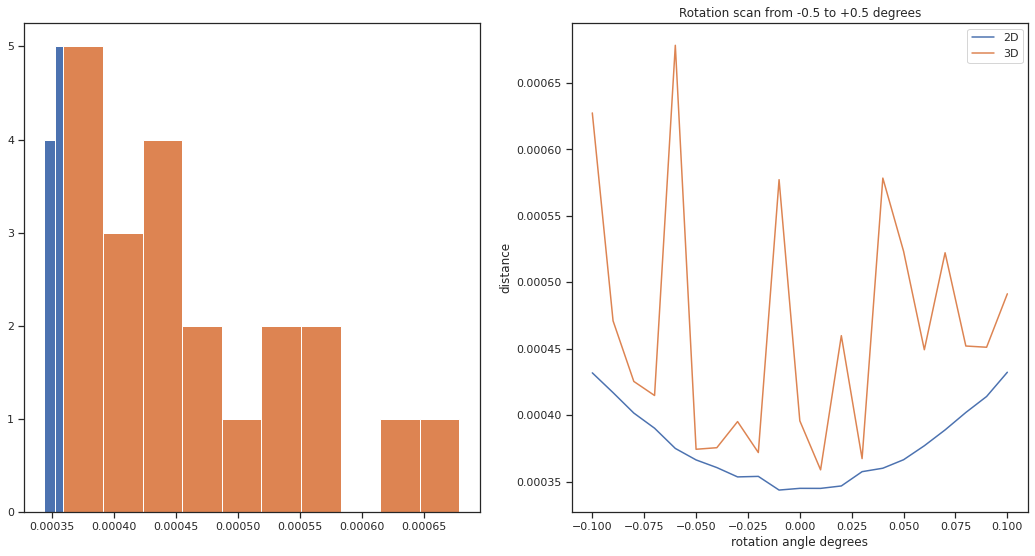

In [98]:
plotter.plot_distances_rotation_scan(angles_list, distances_2d_L1rot, distances_3d_L1rot)